# Predicting the next word 

In [16]:
# Importing the libraries:

import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional , Dropout

Shakespeare Sonnets Dataset, which contains more than 2000 lines of text extracted from Shakespeare's sonnets.

In [ ]:
!pip install gdown==4.6.0

In [3]:
# sonnets.txt    Dataset:
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

C:\Users\PMLS\AppData\Local\Programs\Python\Python311\Lib\site-packages\gdown\cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: c:\Users\PMLS\Desktop\Personal\Coursera\NLP\Next_word_prediction\sonnets.txt

  0%|          | 0.00/93.6k [00:00<?, ?B/s]
100%|██████████| 93.6k/93.6k [00:00<00:00, 261kB/s]
100%|██████████| 93.6k/93.6k [00:00<00:00, 261kB/s]


# Preprocessing Data

In [2]:
# Define path for file with sonnets

SONNETS_FILE = './sonnets.txt'

# Read the data :

with open('./sonnets.txt') as f:
    
    data = f.read()

# Convert to lower case and save as a list

corpus = data.lower().split("\n")

print(f"There are {len(corpus)} lines of sonnets\n")

print(f"The first 5 lines look like this:\n")

for i in range(5):
    
  print(corpus[i])


There are 2159 lines of sonnets

The first 5 lines look like this:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


# Tokenize the text 

In [4]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index) + 1


In [5]:
corpus[0]

'from fairest creatures we desire increase,'

In [6]:
# Text to sequence :

tokenizer.texts_to_sequences([corpus[0]])[0]            # Providing corpus as a string so it can create an accurate sequence

[34, 417, 877, 166, 213, 517]

# N-Gram sequence 

In [7]:
def n_gram_seqs(corpus , tokenizer):
    
    input_sentences = []
    
    for line in corpus:
        
        tokens = tokenizer.texts_to_sequences([line])[0]
        
        # generate unigra,s , bigrams , trigrams
        
            
        for i in range(1 , len(tokens) ):
            
                n_grams = tokens[ : i+1]
                
                input_sentences.append(n_grams)
            
            
    return input_sentences

In [8]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)


print("n_gram sequences for first example look like this:\n")

first_example_sequence

n_gram sequences for first example look like this:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [9]:
# apply n_gram transfprmation on whole corpuse :


input_sequences = n_gram_seqs(corpus , tokenizer)

# Save max length 

max_sequence_len = max([len(x) for x in input_sequences])


print(f"n_grams of input_sequences have length: {len(input_sequences)}")

print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 15462
maximum length of sequences is: 11


# Padding the sequencea

In [10]:
def pad_seqs(input_sequences, maxlen):

    padded_sequences = pad_sequences(input_sequences , maxlen = maxlen , padding = 'pre')

    return padded_sequences

In [11]:
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))

first_padded_seq

array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]])

In [12]:
# Pad the whole corpus

input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (15462, 11)


# Split data into features and labels 

In [13]:
def features_and_labels(input_sequences , total_words):
    
    features = []
    
    one_hot_labels = []
    
    # Iterate over each input  
    
    for seq in input_sequences:
        
        features.append(seq[ : -1])
        
        one_hot_labels.append(to_categorical(seq[-1 ] , num_classes = total_words) )
        
        
    # convert labels and features to numpy array :
    
    features = np.array(features)
    
    one_hot_labels = np.array(one_hot_labels)
    
    
    return features , one_hot_labels

In [14]:
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels have shape: {first_labels.shape}")

print("\nfeatures look like this:\n")

first_features

labels have shape: (5, 3211)

features look like this:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]])

In [15]:
features, labels = features_and_labels(input_sequences, total_words)


print(f"features have shape: {features.shape}")

print(f"labels have shape: {labels.shape}")

features have shape: (15462, 10)
labels have shape: (15462, 3211)


# Model

In [21]:
def create_model(total_words, max_sequence_len):
    
    model = Sequential()
    
    model.add(Embedding(total_words , 100 , input_length = max_sequence_len - 1))
    
    model.add(Bidirectional(LSTM(150 , return_sequences= True)))
    
    model.add(Dropout(0.2))
    
    model.add(LSTM(100))
    
    model.add(Dense(total_words /2 , activation = 'relu'))
    
    model.add(Dense(total_words , activation = 'softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics = 'accuracy')
    
    return model

In [22]:
# Get the untrained model
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(features, labels, epochs=50, verbose=1)


Epoch 1/50


484/484 [==============================] - 64s 119ms/step - loss: 6.8044 - accuracy: 0.0226
Epoch 2/50
484/484 [==============================] - 52s 107ms/step - loss: 6.4341 - accuracy: 0.0313
Epoch 3/50
484/484 [==============================] - 51s 104ms/step - loss: 6.2278 - accuracy: 0.0366
Epoch 4/50
484/484 [==============================] - 51s 105ms/step - loss: 6.0096 - accuracy: 0.0424
Epoch 5/50
484/484 [==============================] - 52s 106ms/step - loss: 5.7637 - accuracy: 0.0508
Epoch 6/50
484/484 [==============================] - 51s 104ms/step - loss: 5.5148 - accuracy: 0.0615
Epoch 7/50
484/484 [==============================] - 50s 104ms/step - loss: 5.2683 - accuracy: 0.0760
Epoch 8/50
484/484 [==============================] - 51s 106ms/step - loss: 5.0207 - accuracy: 0.0867
Epoch 9/50
484/484 [==============================] - 50s 104ms/step - loss: 4.7627 - accuracy: 0.1023
Epoch 10/50
484/484 [==============================] - 456s 944ms/step

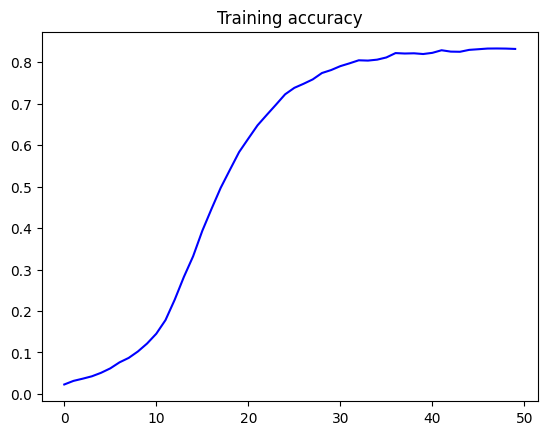

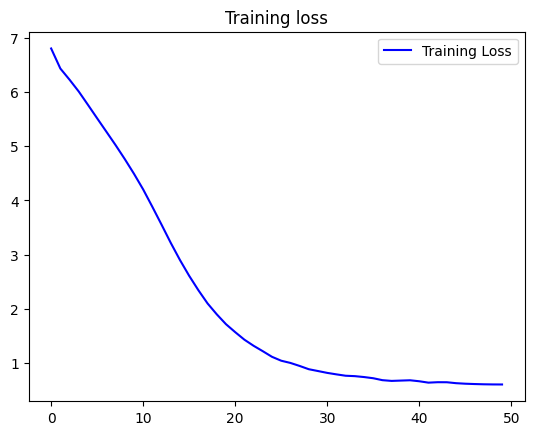

In [23]:
# Take a look at the training curves of model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()